In [1]:
import numpy as np
import scipy.io as scio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import seaborn as sns
import cartopy
import matplotlib
from cartopy.util import add_cyclic_point
from matplotlib.colors import BoundaryNorm

def central_transform(data2D):
    data2D_new=np.full((360,180),np.nan)
    data2D_new[180:361,:]=data2D[20:200,:]
    data2D_new[0:160,:]=data2D[200:360,:]
    data2D_new[160:180,:]=data2D[0:20,:]
    return data2D_new

def reduced_dimension(variable_2D_lon_lat,times=4):
    signal_divide_noise1_reduced = variable_2D_lon_lat.copy()
    for i in range(360):
        for j in range(180):
            if i % times != 0 or j % times != 0:
                signal_divide_noise1_reduced[i, j] = np.nan
    return signal_divide_noise1_reduced

C:\Users\dell\.conda\envs\myenv2\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
#### create a colorbar for colorbar.png
import matplotlib.image as mpimg
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load the colorbar image
img = mpimg.imread('./colorbar.png')

# Resize the image for easier processing
resize_factor = 0.1  # Resize to 10% of the original size
small_img = img[::int(1/resize_factor), ::int(1/resize_factor), :]

# Extract colors along the horizontal center of the resized image
center_y_small = small_img.shape[0] // 2
colors_horizontal_small = small_img[center_y_small, :, :3]  # Extract RGB values

# print(len(colors_horizontal_small))
cmap_1=colors_horizontal_small[0:25]
cmap_2=colors_horizontal_small[25:50]
cmap_3=colors_horizontal_small[50:75]
cmap_4=colors_horizontal_small[75:100]

# Create a new colormap from the extracted colors
new_cmap = ListedColormap(colors_horizontal_small)

# Convert the selected colors into a new colormap
selected_cmap_1 = ListedColormap(cmap_1)
selected_cmap_2 = ListedColormap(cmap_2)
selected_cmap_3 = ListedColormap(cmap_3)
selected_cmap_4 = ListedColormap(cmap_4)

In [3]:
######### load data
data=scio.loadmat('./Input_data/magnitude_upper2001000_T.mat')  #load latitude and lognitude array
lon=data['lon'][:]
lat=data['lat'][:]

### load the magnitude, intensity, and duration data to determine the medium and high exposure regions
data=np.load('./Input_data/Magnitude_low_medium_high_flag_upper200.npz')
magnitude_200_T_flag = data['magnitude_200_T_flag']
magnitude_200_S_flag = data['magnitude_200_S_flag']
magnitude_200_DO_flag = data['magnitude_200_DO_flag']
magnitude_overlap_200_T_S_flag = data['magnitude_overlap_200_T_S_flag']
magnitude_overlap_200_T_DO_flag = data['magnitude_overlap_200_T_DO_flag']
magnitude_overlap_200_T_S_DO_flag = data['magnitude_overlap_200_T_S_DO_flag']

data=np.load('./Input_data/Intensity_low_medium_high_flag_upper200.npz')
intensity_200_T_flag = data['intensity_200_T_flag']
intensity_200_S_flag = data['intensity_200_S_flag']
intensity_200_DO_flag = data['intensity_200_DO_flag']
intensity_overlap_200_T_S_flag = data['intensity_overlap_T_S_flag']
intensity_overlap_200_T_DO_flag = data['intensity_overlap_T_DO_flag']
intensity_overlap_200_T_S_DO_flag = data['intensity_overlap_T_S_DO_flag']

data=np.load('./Input_data/Duration_low_medium_high_flag_upper200.npz')
duration_200_T_flag = data['duration_200_T_flag']
duration_200_S_flag = data['duration_200_S_flag']
duration_200_DO_flag = data['duration_200_DO_flag']
duration_overlap_200_T_S_flag = data['duration_overlap_200_T_S_flag']
duration_overlap_200_T_DO_flag = data['duration_overlap_200_T_DO_flag']
duration_overlap_200_T_S_DO_flag = data['duration_overlap_200_T_S_DO_flag']

### load mean 2013–2020 total fishing effort data (reference from Kroodsma et al. 2018)
data=scio.loadmat('./Input_data/fishing_activities_effort.mat')
fishing_effort=data['global_fishing_effort_mean'][:]
fishing_effort[:,0:20]=np.nan
fishing_effort[:,158:180]=np.nan

In [4]:
####### find T+S+DO overlap grid
exposure_single_emergence_flag = np.full((360, 180),np.nan)
exposure_double_emergence_flag = np.full((360, 180),np.nan)
exposure_triple_emergence_flag = np.full((360, 180),np.nan)
for i in range(360):
    for j in range(180):
        if(~np.isnan(magnitude_200_T_flag[i,j])):
            data=np.array([magnitude_200_T_flag[i,j],intensity_200_T_flag[i,j],duration_200_T_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):  ### high exposure: at least two parameter shows 'high'=3
                exposure_single_emergence_flag[i,j]=1
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                pass
            else:
                exposure_single_emergence_flag[i,j]=1 #other cases: medium exposure

        if(~np.isnan(magnitude_200_S_flag[i,j])):
            data=np.array([magnitude_200_S_flag[i,j],intensity_200_S_flag[i,j],duration_200_S_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):
                exposure_single_emergence_flag[i,j]=1
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                pass
            else:
                exposure_single_emergence_flag[i,j]=1 #other cases: medium exposure

        if(~np.isnan(magnitude_200_DO_flag[i,j])):
            data=np.array([magnitude_200_DO_flag[i,j],intensity_200_DO_flag[i,j],duration_200_DO_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):
                exposure_single_emergence_flag[i,j]=1
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                pass
            else:
                exposure_single_emergence_flag[i,j]=1 #other cases: medium exposure
                
        if(~np.isnan(magnitude_overlap_200_T_S_flag[i,j])):
            data=np.array([magnitude_overlap_200_T_S_flag[i,j],intensity_overlap_200_T_S_flag[i,j],duration_overlap_200_T_S_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):
                exposure_double_emergence_flag[i,j]=2
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                pass
            else:
                exposure_double_emergence_flag[i,j]=2 #other cases: medium exposure
                
        if(~np.isnan(magnitude_overlap_200_T_DO_flag[i,j])):
            data=np.array([magnitude_overlap_200_T_DO_flag[i,j],intensity_overlap_200_T_DO_flag[i,j],duration_overlap_200_T_DO_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):
                exposure_double_emergence_flag[i,j]=2
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                pass
            else:
                exposure_double_emergence_flag[i,j]=2 #other cases: medium exposure
                
        if(~np.isnan(magnitude_overlap_200_T_S_DO_flag[i,j])):
            data=np.array([magnitude_overlap_200_T_S_DO_flag[i,j],intensity_overlap_200_T_S_DO_flag[i,j],duration_overlap_200_T_S_DO_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):
                exposure_triple_emergence_flag[i,j]=3
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                exposure_triple_emergence_flag[i,j]=0
            else:
                exposure_triple_emergence_flag[i,j]=3 #other cases: medium exposure

########## combine all single emergence
index=np.where(~np.isnan(exposure_triple_emergence_flag))
exposure_single_emergence_flag[index]=np.nan
index=np.where(~np.isnan(exposure_double_emergence_flag))
exposure_single_emergence_flag[index]=np.nan

exposure_double_emergence_flag_reduce=reduced_dimension(exposure_double_emergence_flag,times=3)   #for friendly visualization
exposure_triple_emergence_flag_reduce=reduced_dimension(exposure_triple_emergence_flag,times=2)

In [5]:
#### transform the data projection central longitude
exposure_single_emergence_flag=central_transform(exposure_single_emergence_flag)
exposure_double_emergence_flag=central_transform(exposure_double_emergence_flag)
exposure_triple_emergence_flag=central_transform(exposure_triple_emergence_flag)
exposure_double_emergence_flag_reduce=central_transform(exposure_double_emergence_flag_reduce)
exposure_triple_emergence_flag_reduce=central_transform(exposure_triple_emergence_flag_reduce)

exposure_single_emergence_flag, cycle_lon = add_cyclic_point(np.transpose(exposure_single_emergence_flag),np.transpose(lon)[0])
exposure_double_emergence_flag, cycle_lon = add_cyclic_point(np.transpose(exposure_double_emergence_flag),np.transpose(lon)[0])
exposure_triple_emergence_flag, cycle_lon = add_cyclic_point(np.transpose(exposure_triple_emergence_flag),np.transpose(lon)[0])
exposure_double_emergence_flag_reduce, cycle_lon = add_cyclic_point(np.transpose(exposure_double_emergence_flag_reduce),np.transpose(lon)[0])
exposure_triple_emergence_flag_reduce, cycle_lon = add_cyclic_point(np.transpose(exposure_triple_emergence_flag_reduce),np.transpose(lon)[0])

fishing_effort=central_transform(fishing_effort)
fishing_effort, cycle_lon = add_cyclic_point(np.transpose(fishing_effort),np.transpose(lon)[0])

In [6]:
#### set the colorbar
white=(1,1,1)

reds=sns.color_palette('Reds',6)
reds=[white,reds[0],reds[2]]
new_reds=matplotlib.colors.ListedColormap(reds,name='new_reds')  #only T 

whites=sns.color_palette('binary',6)
whites=[white,whites[1],whites[3]]
new_whites=matplotlib.colors.ListedColormap(whites,name='new_whites')  # only S 

purples=sns.color_palette('Purples_r',16)
purples=[white,purples[6],purples[0]]  
new_purples=matplotlib.colors.ListedColormap(purples,name='new_purples')  #### only DO 

C:\Users\dell\.conda\envs\myenv2\lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contourf(*args, **kwargs)
C:\Users\dell\.conda\envs\myenv2\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\dell\.conda\envs\myenv2\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


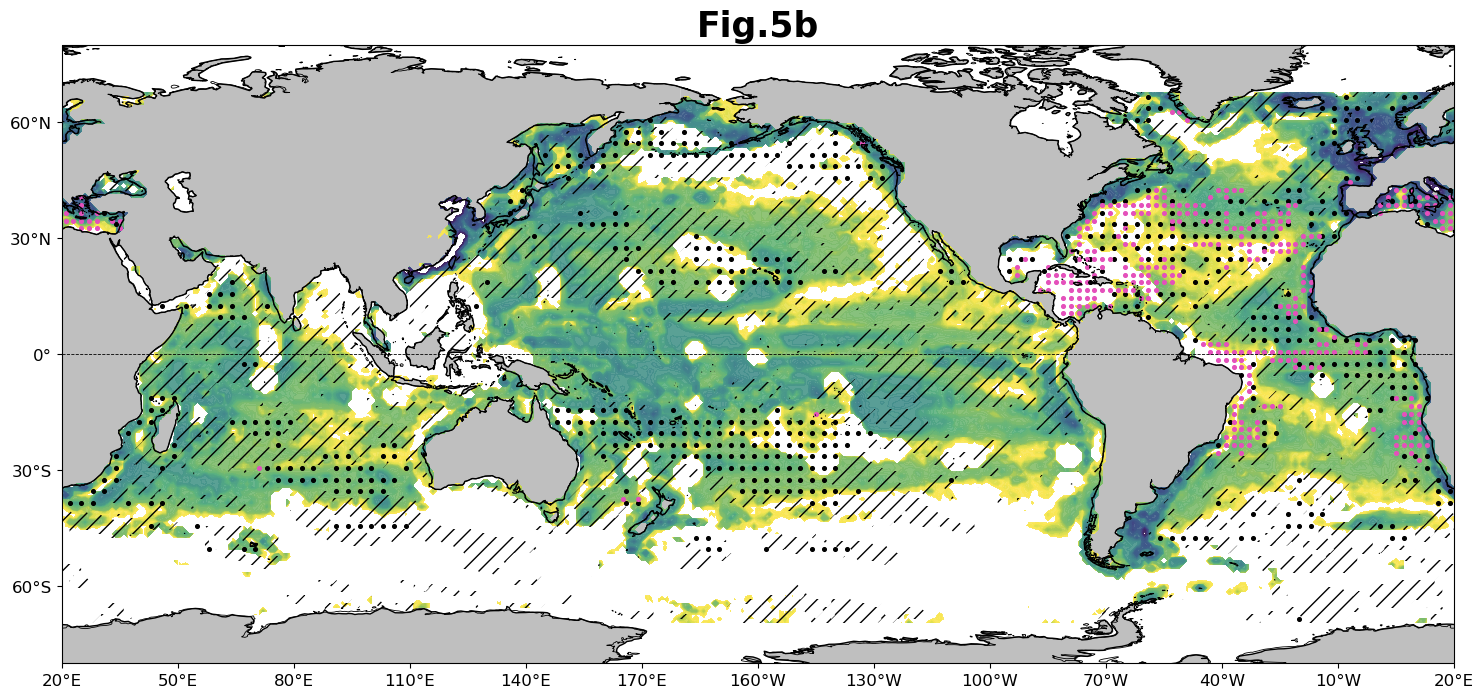

In [8]:
###### plot overlap
lon2d,lat2d=np.meshgrid(cycle_lon,lat)
fig=plt.figure(figsize=(15, 23))
plt.rcParams['font.size'] = '12' 
box=[-180,180,-90,90] 
scale='50m'
xstep,ystep=30,30
proj=ccrs.PlateCarree(central_longitude=200)
ax2=plt.axes(projection=proj)   #create map and projection
ax2.plot([-180,180],[0,0],'--',linewidth=0.6,transform=proj,color='black')
ax2.add_feature(cfeature.LAND, facecolor='0.75') # land color
ax2.add_feature(cfeature.COASTLINE, facecolor='0.75')
ax2.coastlines(scale,linewidth=0.6) 
ax2.set_xticks(np.arange(box[0], box[1] + xstep, xstep), crs=proj)
ax2.set_yticks(np.arange(box[2], box[3] + ystep, xstep), crs=proj)
lon_formatter = LongitudeFormatter(zero_direction_label=False) 
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter) 
ax2.yaxis.set_major_formatter(lat_formatter)  
ax2.set_extent([-180,180,-80,80],crs=proj)

#### plot contour lines in different interval
interval_1=np.linspace(0.001,0.01,25)
cb1=ax2.contourf(lon2d,lat2d,fishing_effort,interval_1,cmap=selected_cmap_1,alpha=0.9,transform=proj)   
interval_2=np.linspace(0.01,0.1,25)
cb2=ax2.contourf(lon2d,lat2d,fishing_effort,interval_2,cmap=selected_cmap_2,alpha=0.9,transform=proj)   
interval_3=np.linspace(0.1,1,25)
cb3=ax2.contourf(lon2d,lat2d,fishing_effort,interval_3,cmap=selected_cmap_3,alpha=0.9,transform=proj)  
interval_4=np.linspace(1,10,25)
cb4=ax2.contourf(lon2d,lat2d,fishing_effort,interval_4,cmap=selected_cmap_4,alpha=0.9,transform=proj)  

#### for friendly visualization
# from scipy.ndimage import label, sum
# labeled_array, num_features = label(exposure_single_emergence_flag)
# area = sum(exposure_single_emergence_flag, labeled_array, range(1, num_features + 1))
# mask = area < 10
# for i, remove in enumerate(mask):
#     if remove:
#         exposure_single_emergence_flag[labeled_array == i + 1] = 0


levels = [0.5, 1.5]
cb2=ax2.contourf(lon2d,lat2d,(exposure_single_emergence_flag),(0,1),hatches=['//'],linewidth=1,cmap=new_whites,alpha=0,transform=proj)

levels = [1,2,3]
row, col = np.where(exposure_double_emergence_flag_reduce == 2)  #insignificant points
lats=lat[row]
lons=cycle_lon[col]
cb3=ax2.scatter(lons, lats, transform=proj, s=7, color='black')  ## plot high exposure regions with dots (double CIDs)

levels = [2,3,4]
row, col = np.where(exposure_triple_emergence_flag_reduce == 3)  #insignificant points
lats=lat[row]
lons=cycle_lon[col]
cb4=ax2.scatter(lons, lats, transform=proj, s=7,color='#e450bb') ## plot high exposure regions with dots (triple CIDs)


#### set colorbar
# cbar1=fig.colorbar(cb1,ax=ax2,boundaries=interval,extend='both', ticks=interval,orientation='horizontal',shrink=0.8,fraction=0.01)
# cbar1=fig.colorbar(cb1,ax=ax2,orientation='horizontal',fraction=0.01)
# cbar2=fig.colorbar(cb2,ax=ax2,orientation='horizontal',fraction=0.01)
# cbar3=fig.colorbar(cb3,ax=ax2,orientation='horizontal',fraction=0.01)
# cbar4=fig.colorbar(cb4,ax=ax2,orientation='horizontal',fraction=0.01)
# cbar4.set_label(r'$(h/km^2)$', size=12, fontweight='bold', color='k')

plt.title('Fig.5b',fontdict={'weight':'bold','size':25})
fig.tight_layout()

plt.savefig('./Fig5b.pdf', dpi=750, bbox_inches='tight')
plt.show()